# Neural Networks for Data Science Applications
## Advanced transfer learning: model merging with Ratatouille technique

**Name**: Francesco Pinto

**Matricola**: 1871045


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_datasets as tfds
from google.colab import drive
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, initializers, regularizers, Model, Input, Sequential
from tensorflow.keras import losses, metrics, optimizers, callbacks
import numpy as np
import pandas as pd
drive.mount('/content/drive', force_remount=True)


sns.set_theme()
plt.rcParams['figure.figsize'] = [12, 6]

In [ ]:
# To ensure reproducible results (as much as possible)
tf.keras.utils.set_random_seed(1234)



# The Data
The purpose of the project is to perform a [**Ratatouille Model Merging**](https://proceedings.mlr.press/v202/rame23a/rame23a.pdf) to obtain the best model to distinguish the different **colorectal tissues** and diseases.


This technique is very efficient because it allows to train multiple Neural Networks with the same architecture on different task separately (so called *auxiliary tasks*), fine-tune the models on the final task of interest, and then merge the models into a single definitive model.

In order to find the best model to classify the colorectal tissues, I decided to use auxiliary data that may help my model as much as possible, so I will train my models on datasets related to the human body: I will initially train the model on **eye disease** dataset and **lungs disease** dataset.

After training the models on the data above, I will fine-tune them on the **colorectal histology** data, and successively merge the models.

### **Eye Disease dataset (auxiliary data 1)**
This dataset contains images of eyes with four different conditions (classes):

- Normal eye
- Eye with glaucoma
- Eye with diabetic reinopathy
- Eye with cataract

Source: <font color=blue>**Kaggle**<font >

### **Lungs disease dataset (auxiliary data 2)**

This dataset contains X-Rays of lungs with four different conditions:

- Viral pneumonia  
- Bacterial pneumonia
- Normal lungs
- Covid-19

Source: <font color=blue>**Kaggle**<font >
### **Colorectal histology data (final data)**
The dataset contains 8 different types of tissue/diseases:

- Tumour epithelium
- Simple stroma
- Complex stroma (containing single tumour cells and/or few immune cells);
- Immune cells
- Debris
- Normal mucosal glands
- Adipose tissue
- Background (no tissue)

Source: <font color=orange>**Tensorflow Datasets**<font >

In [ ]:
# auxiliary data 1: eye disease
train_data_dir = '/content/drive/MyDrive/Final Homework Neural Networks/eye_disease'
batch_size = 16
img_width, img_height = 100, 100


#this is the augmentation configuration I will use for training and validating
train_datagen = ImageDataGenerator(
    rescale=1/255,
    validation_split=0.2)

train_aux1 = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset = 'training')

val_aux1 = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset = 'validation')

Found 1973 images belonging to 4 classes.
Found 491 images belonging to 4 classes.


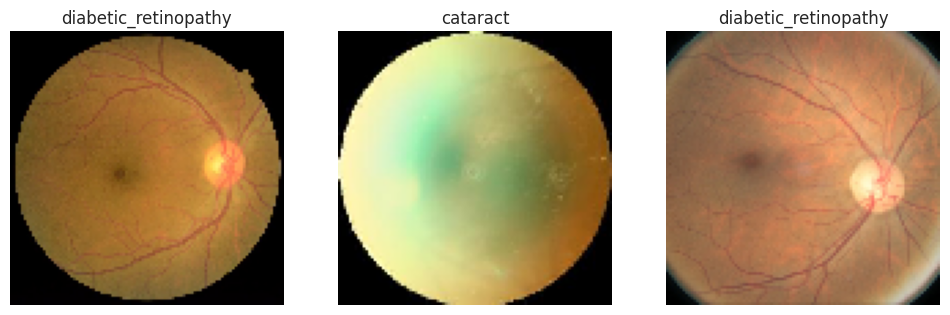

In [ ]:
plt.rcParams['figure.figsize'] = [12, 6]

batch_images, batch_labels = next(train_aux1)
num_images = 3

class_mapping = train_aux1.class_indices
inverse_mapping = {v: k for k, v in class_mapping.items()}

for i in range(num_images):
    plt.subplot(1, num_images, i+1)
    plt.imshow(batch_images[i])
    label = [i for i, value in enumerate(batch_labels[i]) if value]
    plt.title(f"{inverse_mapping[label[0]]}")
    plt.axis('off')

plt.show()

In [ ]:
# auxiliary data 2: lungs disease
train_data_dir = '/content/drive/MyDrive/Final Homework Neural Networks/lungs_disease'
batch_size = 16
img_width, img_height = 100, 100



train_datagen = ImageDataGenerator(
    rescale=1/255,
    validation_split=0.2)

train_aux2 = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset = 'training')

val_aux2 = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset = 'validation')

Found 4999 images belonging to 4 classes.
Found 1248 images belonging to 4 classes.


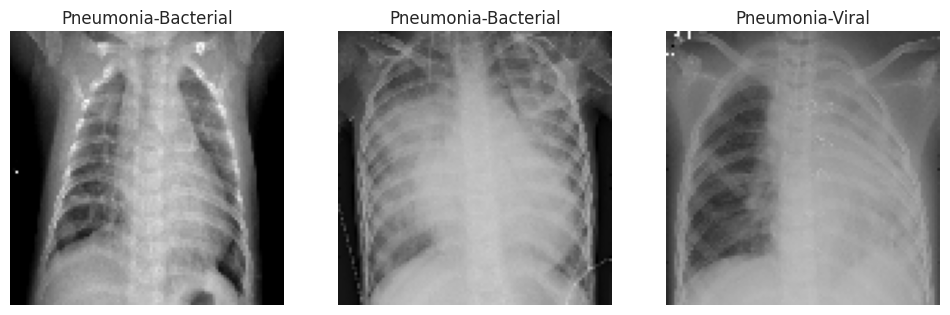

In [ ]:
plt.rcParams['figure.figsize'] = [12, 6]

batch_images, batch_labels = next(train_aux2)
num_images = 3

class_mapping = train_aux2.class_indices
inverse_mapping = {v: k for k, v in class_mapping.items()}

for i in range(num_images):
    plt.subplot(1, num_images, i+1)
    plt.imshow(batch_images[i])
    label = [i for i, value in enumerate(batch_labels[i]) if value]
    plt.title(f"{inverse_mapping[label[0]]}")
    plt.axis('off')

plt.show()

In [ ]:
# task data: colorectal histology
# this code-cell has been taken from my last homework
train_task1, t_info_task = tfds.load('colorectal_histology', as_supervised = True, split = 'train[:70%]', with_info = True)
val_task = tfds.load('colorectal_histology', as_supervised = True, split = 'train[70%:80%]')
test_task = tfds.load('colorectal_histology', as_supervised = True, split = 'train[80%:100%]')
num_classes = 8


def processing(image, label):
  #Image Croppng
  image = tf.image.resize(image, (100, 100))
  #Casting & Scaling
  image = tf.cast(image, tf.float32) / 255
  #Casting also the labels in order to avoid errors during training
  label = tf.cast(label, tf.float32)
  return image, label

train_task = train_task1.map(processing).batch(32)
val_task = val_task.map(processing).batch(32)
test_task = test_task.map(processing).batch(32)

In [ ]:
classes = t_info_task.features['label'].names
class_mapping = {name: i for i, name in enumerate(classes)}

class_mapping

{'tumor': 0,
 'stroma': 1,
 'complex': 2,
 'lympho': 3,
 'debris': 4,
 'mucosa': 5,
 'adipose': 6,
 'empty': 7}

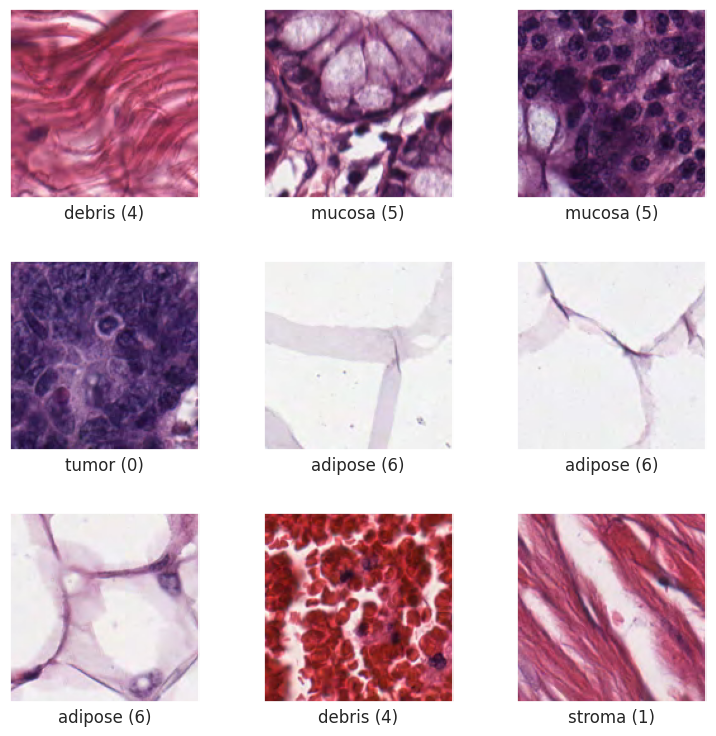

In [ ]:
tfds.show_examples(train_task1, t_info_task)
plt.show()


# Ratatouille Model Merging

The purpose of this project is to perform a **Ratatouille Model Merging** to predict the different colorectal tissues and the diseases of it.

This model from Meta is a good transfer learning approach, because it fine-tunes different models twice: the first time on the auxiliary tasks and the second time on the target task.

These models are then merged into a final model, where the parameters of the fine-tuned featurizers are averaged.


In the figure below we can see the difference between Ratatouille and different transfer learning techniques:



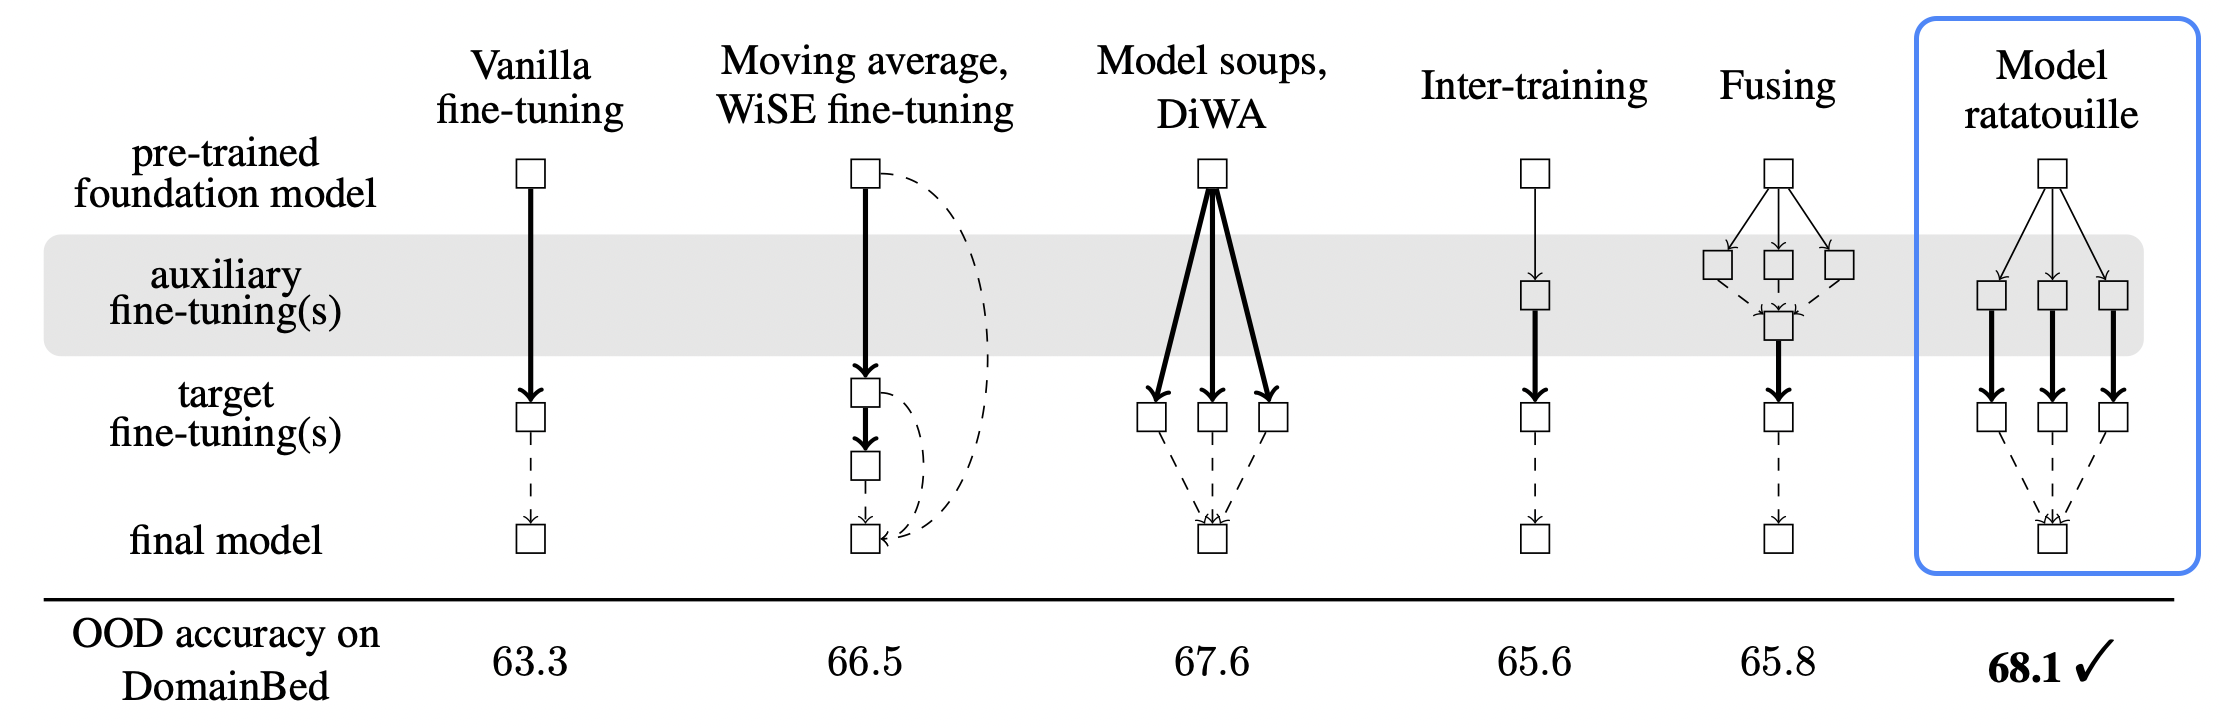

**Quick notation**
- $\phi_j$ is the notation for the featurizer $j$ (model)
- $w$ is the notation for the classification layer
- $^{pt}$ is the index that we use to define a pre-trained object
- $^{lp}$ is the index that we use to define a linear-probed classification layer (a layer that has been trained on the target task)
- $^{aux}$ is the index that we use to say that a model has been trained on an auxiliary task

e.g. $(w^{lp}, \phi_1^{aux})$ is the model $1$ that has been trained on an auxiliary task, with the linear-probed layer concatenated as classification layer.


More specifically, the model merging will be structured as follows:

1. *Initialization*: A pre-trained **ResNet-50** will be used as base model ($\phi^{pt}$)
2. *Training the classification layer*: We train a classification layer $w^{lp}$ - concatenated to a non-trainable ResNet-50 - on the final task (colorectal histology). This linear-probed layer will be used in the next steps.
3. *Training on the auxiliary task*: In addition to the basic pre-trained ResNet ($\phi_0^{pt}$), we train two different ResNets on two auxiliary task: the prediction of the **eye disease** ($\phi_1^{pt}$) and the prediction of the **skin disease** ($\phi_2^{pt}$). At the end of this step, we will have three different pre-trained models.
4. *Concatenation of the classification layer*: We substitute the classification layers of the three models with the linear probed one, $w^{lp}$.
5. *Fine-tuning*: We fine-tune the three models on the final task with the new classification layer
6. *Model Averaging*: We finally average the parameters of the models and obtain the final model

In the figure below we can see the steps performed in the analysis:

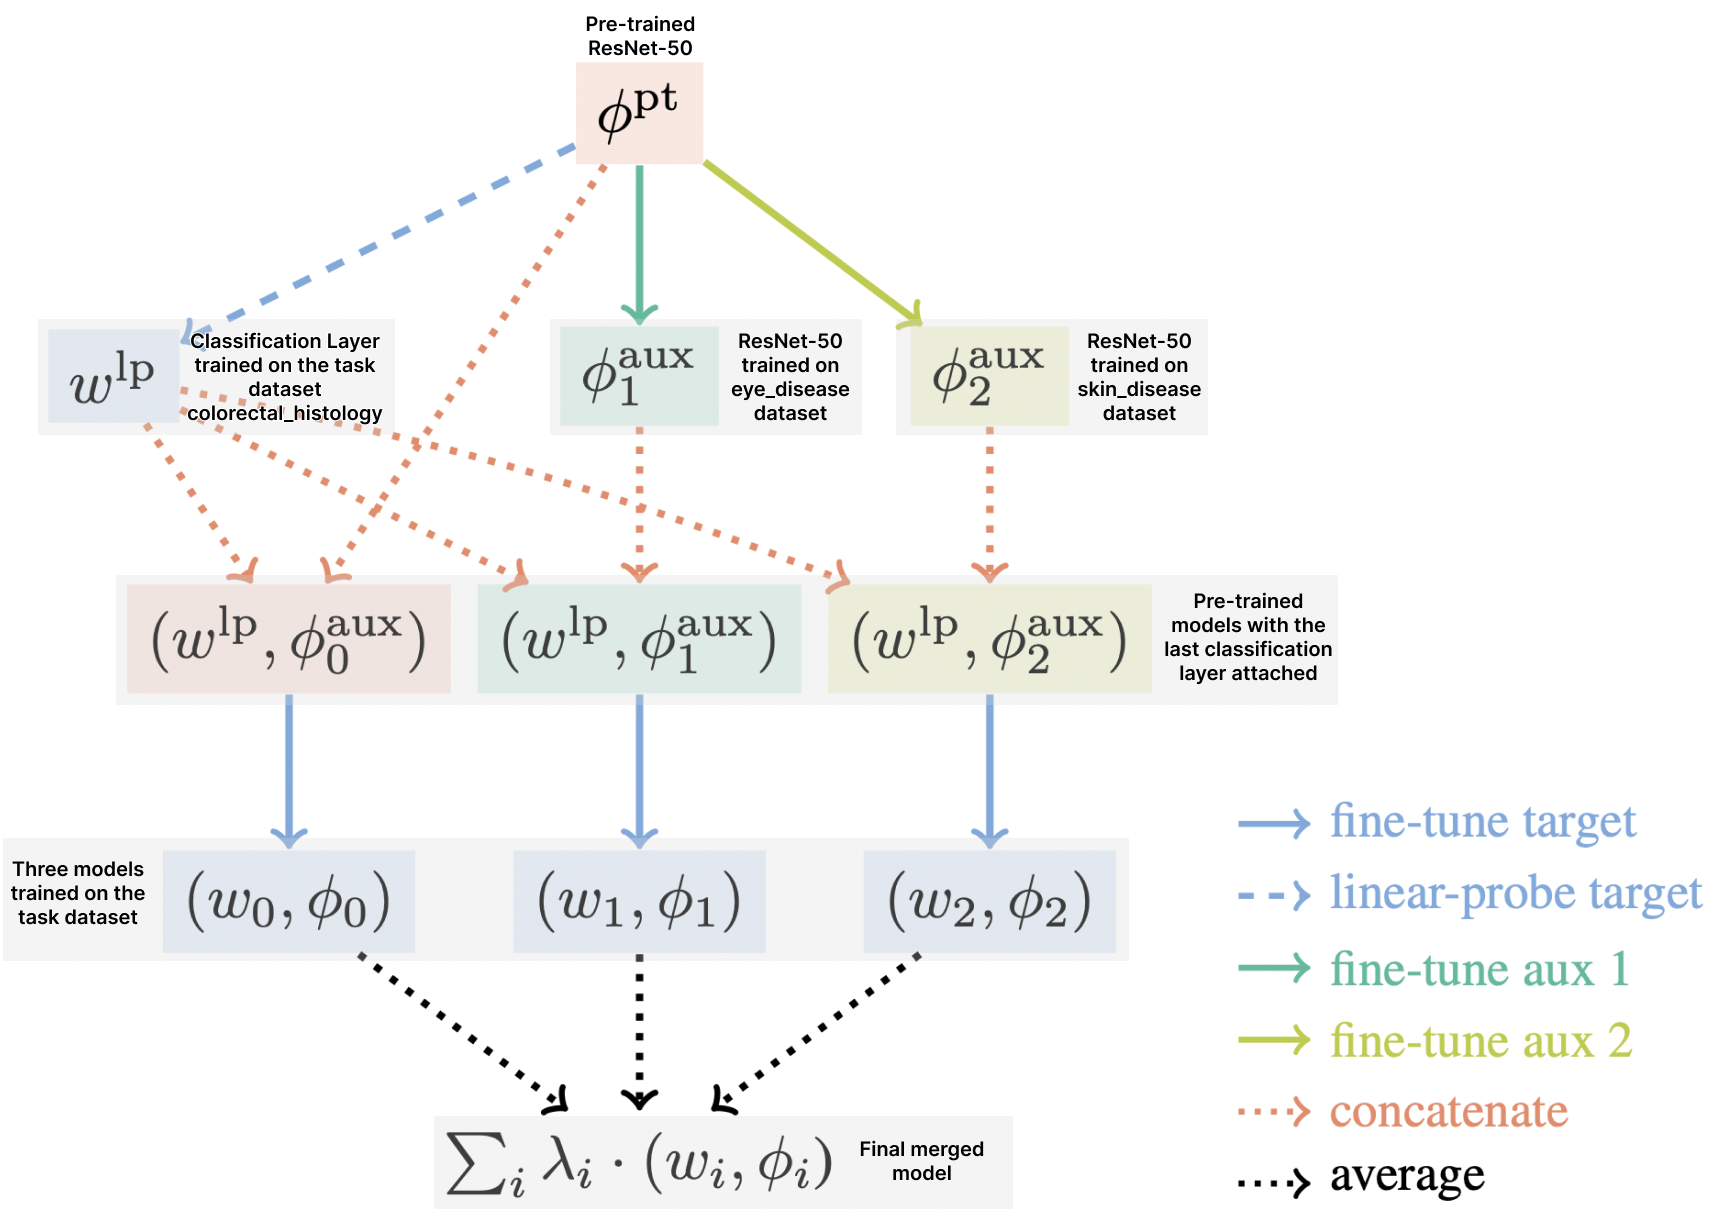

[Note]: The two figures have been taken from the original paper, but the second figure has been customized by me,  to make it more comprehensible what I'm doing in the project.


### 1. Initialization: uploading the pre-trained model $\phi^{pt}$

Here we define the three ResNets that will be integrated to the three models later.

[It's not necessary to define them three times, I'm doing it to make it more clear that we are working on three different models.]

In [ ]:
base_model_0 = tf.keras.applications.resnet50.ResNet50(
    input_shape=(100, 100, 3),
    # With this command, we import the model without the final classification layer:
    include_top=False,
    # This variable sets the pre-trained weights of imagenet:
    weights='imagenet',
    pooling = 'avg')

base_model_1 = tf.keras.applications.resnet50.ResNet50(
    input_shape=(100, 100, 3),
    include_top=False,
    weights='imagenet',
    pooling = 'avg')

base_model_2 = tf.keras.applications.resnet50.ResNet50(
    input_shape=(100, 100, 3),
    include_top=False,
    weights='imagenet',
    pooling = 'avg')

94765736/94765736 [==============================] - 0s 0us/step


### 2: Training the classification layer $w^{lp}$
In order to perform a better classification task, we train the classification layer directly on the task dataset, so we can have a faster fine-tuning later, as suggested on the paper.


In [ ]:
# w_lp is the linear-probed final layer (w^(lp)).

# Here we train the final classification layer, trained to have 8 classes as output

w_lp = Sequential([
    tf.keras.Input(shape=(100, 100, 3)),
    tf.keras.applications.resnet.ResNet50(include_top=False, input_shape=(100, 100, 3),
                                          pooling = 'avg', weights = 'imagenet'),
    layers.Dense(8, activation = 'softmax')
])

#Layer 0 is the resnet50 layer
w_lp.layers[0].trainable = False

#Layer 1 is the classification layer, that we want to train
w_lp.layers[1].trainable = True


# Here the output is an integer, so I use the "Sparse CE"
w_lp.compile(optimizer= 'adam',
              loss='sparse_categorical_crossentropy',
              metrics='accuracy')
w_lp.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_1 (Dense)             (None, 8)                 16392     
                                                                 
Total params: 23604104 (90.04 MB)
Trainable params: 16392 (64.03 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


We don't expect big performances from this layer: even if we go through the dataset multiple times, the dense layer is just a linear layer and it cannot return accurate performances for this task.

In [ ]:
performance = w_lp.fit(train_task, epochs=15, validation_data = val_task)

Epoch 1/15
110/110 [==============================] - 9s 46ms/step - loss: 1.9753 - accuracy: 0.2434 - val_loss: 1.8476 - val_accuracy: 0.2800
Epoch 2/15
110/110 [==============================] - 4s 33ms/step - loss: 1.7858 - accuracy: 0.3291 - val_loss: 1.7245 - val_accuracy: 0.3040
Epoch 3/15
110/110 [==============================] - 4s 35ms/step - loss: 1.6879 - accuracy: 0.3751 - val_loss: 1.6459 - val_accuracy: 0.3220
Epoch 4/15
110/110 [==============================] - 4s 33ms/step - loss: 1.6196 - accuracy: 0.4037 - val_loss: 1.5889 - val_accuracy: 0.3460
Epoch 5/15
110/110 [==============================] - 4s 34ms/step - loss: 1.5676 - accuracy: 0.4214 - val_loss: 1.5447 - val_accuracy: 0.3560
Epoch 6/15
110/110 [==============================] - 4s 37ms/step - loss: 1.5260 - accuracy: 0.4351 - val_loss: 1.5089 - val_accuracy: 0.3820
Epoch 7/15
110/110 [==============================] - 4s 35ms/step - loss: 1.4916 - accuracy: 0.4497 - val_loss: 1.4789 - val_accuracy: 0.3960

### 3.1: Training $\phi_1^{aux}$ on the first auxiliary data

The next step is to train the ResNet-50 on the first auxiliary dataset: **eye_disease** data.

In this step, we train the first auxiliary model

In [ ]:
base_model_1.trainable = True
def model_aux1(num_classes_aux1 = 4):
    inputs = tf.keras.Input(shape=(100, 100, 3))
    x = base_model_1(inputs)
    out = tf.keras.layers.Dense(num_classes_aux1, activation='softmax')(x)
    model = tf.keras.Model(inputs, out)
    return model

# Here the output is ohe-hot encoded, so I use the non-sparse CE
Model_aux1 = model_aux1()
Model_aux1.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = 'accuracy')
Model_aux1.fit(train_aux1, epochs = 20, batch_size = 32, validation_data = val_aux1)

Epoch 1/20
124/124 [==============================] - 860s 7s/step - loss: 0.7931 - accuracy: 0.7603 - val_loss: 2.7709 - val_accuracy: 0.4216
Epoch 2/20
124/124 [==============================] - 30s 240ms/step - loss: 0.2626 - accuracy: 0.9057 - val_loss: 1.6546 - val_accuracy: 0.4216
Epoch 3/20
124/124 [==============================] - 29s 237ms/step - loss: 0.2696 - accuracy: 0.9067 - val_loss: 4.1429 - val_accuracy: 0.1690
Epoch 4/20
124/124 [==============================] - 29s 236ms/step - loss: 0.1601 - accuracy: 0.9498 - val_loss: 2.1979 - val_accuracy: 0.1731
Epoch 5/20
124/124 [==============================] - 30s 237ms/step - loss: 0.1410 - accuracy: 0.9574 - val_loss: 2.8003 - val_accuracy: 0.4196
Epoch 6/20
124/124 [==============================] - 30s 244ms/step - loss: 0.1334 - accuracy: 0.9508 - val_loss: 2.8403 - val_accuracy: 0.4582
Epoch 7/20
124/124 [==============================] - 29s 237ms/step - loss: 0.1411 - accuracy: 0.9473 - val_loss: 2.7493 - val_accu

### 3.2: Training $\phi_2^{aux}$ on the second auxiliary data


In [ ]:
base_model_2.trainable = True

def model_aux2(num_classes_aux2 = 4):
    inputs = tf.keras.Input(shape=(100, 100, 3))
    x = base_model_2(inputs)
    out = tf.keras.layers.Dense(num_classes_aux2, activation='softmax')(x)
    model = tf.keras.Model(inputs, out)
    return model

# Here the output is ohe-hot encoded, so I use the non-sparse CE
Model_aux2 = model_aux2()
Model_aux2.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = 'accuracy')
Model_aux2.fit(train_aux2, epochs = 20, batch_size = 64, validation_data = val_aux2)

Epoch 1/20
313/313 [==============================] - 2578s 8s/step - loss: 0.7365 - accuracy: 0.7065 - val_loss: 1.6353 - val_accuracy: 0.4808
Epoch 2/20
313/313 [==============================] - 105s 335ms/step - loss: 0.5146 - accuracy: 0.7608 - val_loss: 1.0130 - val_accuracy: 0.6378
Epoch 3/20
313/313 [==============================] - 96s 306ms/step - loss: 0.4776 - accuracy: 0.7820 - val_loss: 0.8433 - val_accuracy: 0.6955
Epoch 4/20
313/313 [==============================] - 94s 301ms/step - loss: 0.4170 - accuracy: 0.8110 - val_loss: 0.7973 - val_accuracy: 0.6923
Epoch 5/20
313/313 [==============================] - 94s 300ms/step - loss: 0.4018 - accuracy: 0.8228 - val_loss: 0.5968 - val_accuracy: 0.7348
Epoch 6/20
313/313 [==============================] - 94s 299ms/step - loss: 0.3432 - accuracy: 0.8502 - val_loss: 0.6578 - val_accuracy: 0.7163
Epoch 7/20
313/313 [==============================] - 92s 293ms/step - loss: 0.2984 - accuracy: 0.8736 - val_loss: 1.8094 - val_ac

### 4: Concatenation of the classification layers ($w^{aux}\rightarrow w^{lp}$)

#### $(w^{lp}, \phi_0^{aux})$
First pre-trained model (trained ResNet50 from Tensorflow) with the linear-probed final layer:

In [ ]:
wlp_phi0aux = tf.keras.Sequential([
    tf.keras.Input(shape=(100, 100, 3)),
    tf.keras.applications.resnet.ResNet50(include_top=False, input_shape=(100, 100, 3),
                                          weights = 'imagenet', pooling = 'avg')
])

# Then we add the linear-probed layer
wlp_phi0aux.add(w_lp.layers[-1])

wlp_phi0aux.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_1 (Dense)             (None, 8)                 16392     
                                                                 
Total params: 23604104 (90.04 MB)
Trainable params: 23550984 (89.84 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


#### $(w^{lp}, \phi_1^{aux})$
Second pre-trained model (ResNet50 trained on eye dataset) with the linear-probed final layer:

In [ ]:
wlp_phi1aux = tf.keras.Sequential()

for layer in Model_aux1.layers[:-1]:
  wlp_phi1aux.add(layer)

wlp_phi1aux.add(w_lp.layers[-1])
wlp_phi1aux.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_1 (Dense)             (None, 8)                 16392     
                                                                 
Total params: 23604104 (90.04 MB)
Trainable params: 23550984 (89.84 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


#### $(w^{lp}, \phi_2^{aux})$
Third pre-trained model (ResNet50 trained on lungs data) with the linear-probed final layer:

In [ ]:
wlp_phi2aux = tf.keras.Sequential()
for layer in Model_aux2.layers[:-1]:
  wlp_phi2aux.add(layer)

wlp_phi2aux.add(w_lp.layers[-1])

wlp_phi2aux.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_1 (Dense)             (None, 8)                 16392     
                                                                 
Total params: 23604104 (90.04 MB)
Trainable params: 23550984 (89.84 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


### 5: Fine-tuning

We now proceed with the fine-tuning of the three models.

#### Model 0

In [ ]:
wlp_phi0aux.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')
wlp_phi0aux.fit(train_task, epochs = 15, batch_size = 32, validation_data = val_task)

Epoch 1/15
110/110 [==============================] - 51s 124ms/step - loss: 2.1696 - accuracy: 0.7037 - val_loss: 1164.7335 - val_accuracy: 0.1040
Epoch 2/15
110/110 [==============================] - 12s 107ms/step - loss: 0.5025 - accuracy: 0.8423 - val_loss: 80.9612 - val_accuracy: 0.1320
Epoch 3/15
110/110 [==============================] - 12s 108ms/step - loss: 0.4651 - accuracy: 0.8854 - val_loss: 3.8600 - val_accuracy: 0.1360
Epoch 4/15
110/110 [==============================] - 12s 109ms/step - loss: 0.4442 - accuracy: 0.8900 - val_loss: 3.6378 - val_accuracy: 0.1500
Epoch 5/15
110/110 [==============================] - 12s 107ms/step - loss: 0.2861 - accuracy: 0.9163 - val_loss: 2.0869 - val_accuracy: 0.2160
Epoch 6/15
110/110 [==============================] - 12s 107ms/step - loss: 0.2180 - accuracy: 0.9366 - val_loss: 5.3271 - val_accuracy: 0.2560
Epoch 7/15
110/110 [==============================] - 12s 108ms/step - loss: 0.1848 - accuracy: 0.9517 - val_loss: 3.1454 - va

In [ ]:
wlp_phi0aux.evaluate(test_task)

32/32 [==============================] - 1s 33ms/step - loss: 0.3201 - accuracy: 0.9220


[0.32011231780052185, 0.921999990940094]

#### Model 1

In [ ]:
wlp_phi1aux.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')
wlp_phi1aux.fit(train_task, epochs = 15, batch_size = 32, validation_data = val_task)

Epoch 1/15
110/110 [==============================] - 49s 118ms/step - loss: 1.3718 - accuracy: 0.6097 - val_loss: 1.3314 - val_accuracy: 0.5520
Epoch 2/15
110/110 [==============================] - 12s 107ms/step - loss: 0.5426 - accuracy: 0.8060 - val_loss: 6.5580 - val_accuracy: 0.6120
Epoch 3/15
110/110 [==============================] - 12s 110ms/step - loss: 0.3619 - accuracy: 0.8691 - val_loss: 0.8215 - val_accuracy: 0.7300
Epoch 4/15
110/110 [==============================] - 12s 110ms/step - loss: 0.2217 - accuracy: 0.9240 - val_loss: 1.2969 - val_accuracy: 0.6060
Epoch 5/15
110/110 [==============================] - 12s 107ms/step - loss: 0.2409 - accuracy: 0.9226 - val_loss: 2.9900 - val_accuracy: 0.3820
Epoch 6/15
110/110 [==============================] - 12s 106ms/step - loss: 0.2864 - accuracy: 0.9097 - val_loss: 0.9588 - val_accuracy: 0.7400
Epoch 7/15
110/110 [==============================] - 12s 109ms/step - loss: 0.1066 - accuracy: 0.9660 - val_loss: 0.6726 - val_ac

In [ ]:
wlp_phi1aux.evaluate(test_task)

32/32 [==============================] - 2s 44ms/step - loss: 3.7494 - accuracy: 0.6780


[3.749392509460449, 0.6779999732971191]

#### Model 2

In [ ]:
wlp_phi2aux.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')
wlp_phi2aux.fit(train_task, epochs = 15, batch_size = 32, validation_data = val_task)

Epoch 1/15
110/110 [==============================] - 44s 118ms/step - loss: 1.0449 - accuracy: 0.6383 - val_loss: 1.2352 - val_accuracy: 0.5980
Epoch 2/15
110/110 [==============================] - 12s 110ms/step - loss: 0.4107 - accuracy: 0.8571 - val_loss: 0.7359 - val_accuracy: 0.7320
Epoch 3/15
110/110 [==============================] - 12s 110ms/step - loss: 0.1699 - accuracy: 0.9443 - val_loss: 0.6605 - val_accuracy: 0.7920
Epoch 4/15
110/110 [==============================] - 12s 106ms/step - loss: 0.0710 - accuracy: 0.9811 - val_loss: 1.1100 - val_accuracy: 0.6820
Epoch 5/15
110/110 [==============================] - 12s 107ms/step - loss: 0.0568 - accuracy: 0.9837 - val_loss: 0.9754 - val_accuracy: 0.7820
Epoch 6/15
110/110 [==============================] - 12s 108ms/step - loss: 0.0307 - accuracy: 0.9934 - val_loss: 0.7206 - val_accuracy: 0.8220
Epoch 7/15
110/110 [==============================] - 12s 107ms/step - loss: 0.0202 - accuracy: 0.9940 - val_loss: 0.7133 - val_ac

In [ ]:
wlp_phi2aux.evaluate(test_task)

32/32 [==============================] - 1s 41ms/step - loss: 0.4937 - accuracy: 0.8740


[0.4936690330505371, 0.8740000128746033]

### 6: Model merging

The final step is to merge the three models.

After multiple tentatives, the best merging performance was given by the averaging of the three models

$$\sum_1^M \lambda_i \cdot (w_i, \phi_i)$$

where $\lambda_i = \frac{1}{M} = \frac{1}{3}$.

Weighting the models based on the performances (i.e. assigning higher weights to the model with higher accuracy) didn't work good.

Let's now observe the performance of the merged model:

In [ ]:
# We now work with lists because the .get_weights() command returns a list of arrays

weighted_0 = [w * 1/3 for w in wlp_phi0aux.get_weights()]

weighted_1 = [w * 1/3 for w in wlp_phi1aux.get_weights()]

weighted_2 = [w * 1/3 for w in wlp_phi2aux.get_weights()]

final_weights = [weighted_0[i] + weighted_1[i] + weighted_1[i] for i in range(len(weighted_0))]

In [ ]:
# Let's define the final model
final_model = Sequential([
    tf.keras.Input(shape=(100, 100, 3)),
    tf.keras.applications.resnet.ResNet50(include_top=False, input_shape=(100, 100, 3),
                                          pooling = 'avg', weights = 'imagenet'),
    layers.Dense(8, activation = 'softmax')
])

final_model.set_weights(final_weights)

In [ ]:
final_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')

final_model.evaluate(test_task)

32/32 [==============================] - 3s 29ms/step - loss: 1.0030 - accuracy: 0.6130


[1.0029733180999756, 0.6129999756813049]

32/32 [==============================] - 2s 54ms/step


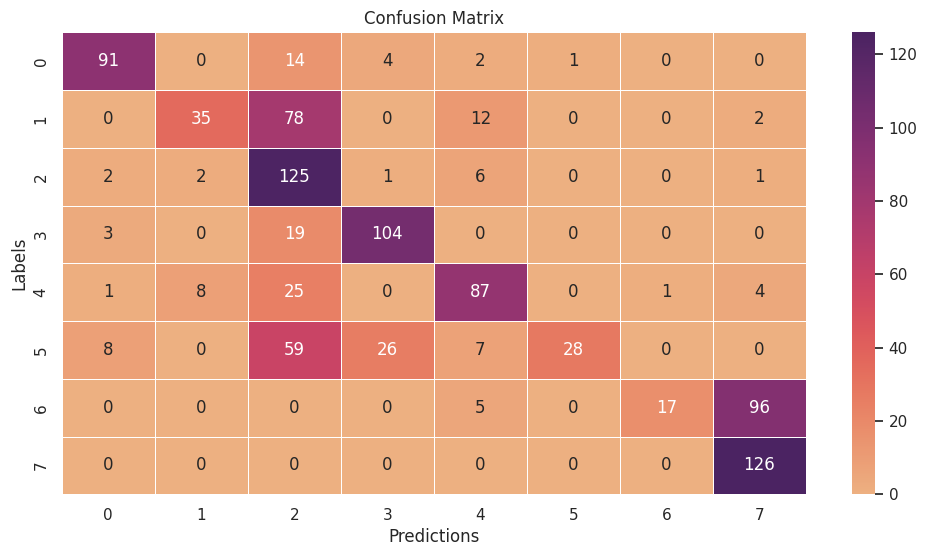

In [ ]:
classes = t_info_task.features['label'].names
class_mapping = {name: i for i, name in enumerate(classes)}

y_pred = final_model.predict(test_task, batch_size=16)
predictions = tf.math.argmax(y_pred, 1)
y_true = np.concatenate([y for x,y in test_task], axis=0)

classes = list(class_mapping.values())
confusion_matrix = tf.math.confusion_matrix(y_true, predictions)
confusion_matrix = pd.DataFrame(confusion_matrix, index = classes, columns = classes)

sns.heatmap(confusion_matrix, annot=True, linewidth= 0.5, cmap = "flare", fmt='g')
plt.title('Confusion Matrix of the merged model')
plt.ylabel('Labels')
plt.xlabel('Predictions')
plt.show()

In [ ]:
class_mapping

{'tumor': 0,
 'stroma': 1,
 'complex': 2,
 'lympho': 3,
 'debris': 4,
 'mucosa': 5,
 'adipose': 6,
 'empty': 7}

The accuracy is sufficient. We can see that the main problems of the model have been class 2 ("complex"), that has been misclassified multiple times, class 6 and 7 that have been confused and class 3 and 5.

In the end, the model has good performance.

### [Not necessary]: performances of the model $\phi_0$

Even if the merged model did not give us the best results, we obtained a very good model with the first fine-tuning: $\phi_0$.



32/32 [==============================] - 1s 34ms/step


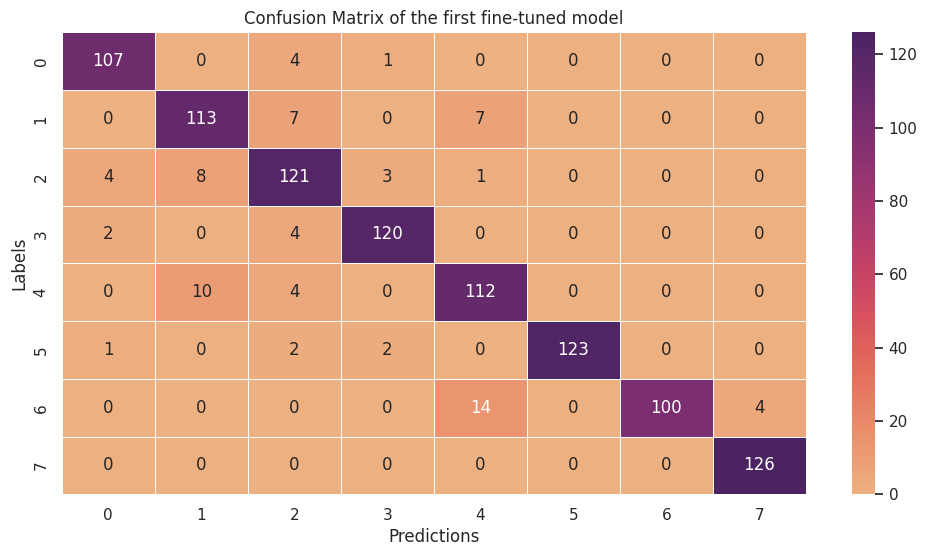

In [ ]:
classes = t_info_task.features['label'].names
class_mapping = {name: i for i, name in enumerate(classes)}

y_pred = wlp_phi0aux.predict(test_task, batch_size=16)
predictions = tf.math.argmax(y_pred, 1)
y_true = np.concatenate([y for x,y in test_task], axis=0)

classes = list(class_mapping.values())
confusion_matrix = tf.math.confusion_matrix(y_true, predictions)
confusion_matrix = pd.DataFrame(confusion_matrix, index = classes, columns = classes)

sns.heatmap(confusion_matrix, annot=True, linewidth= 0.5, cmap = "flare", fmt='g')
plt.title('Confusion Matrix of the first fine-tuned model')
plt.ylabel('Labels')
plt.xlabel('Predictions')
plt.show()

Transfer learning, in this case, gave us a very precise model!